# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


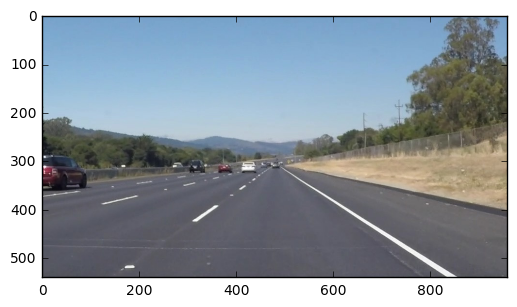

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform
    lower threshold and higher threshold
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines != None : #if no lines left or right are detected
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hpass_angle_filter(lines, angle_threshold):  
    """ 
    High Pass angle filter: drop all lines with an angle below the threshold
    
    """
    if lines != None : #if no lines left or right are detected
        filtered_lines = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                angle = abs(np.arctan( (y2-y1)/(x2-x1) ) * 180/np.pi )
                if angle > angle_threshold:
                    filtered_lines.append([[x1,y1,x2,y2]])
        return filtered_lines          
                
def average_lines(img, lines, y_min, y_max):
    """
     return coordinates of the averaged lines
    """
    hough_pts = {'m_left': [], 'b_left':[], 'norm_left':[], 'm_right': [], 'b_right':[], 'norm_right':[]}
    if lines != None : #if no lines left or right are detected
        for line in lines:
            for x1,y1,x2,y2 in line:
                m, b = np.polyfit([x1,x2], (y1,y2), 1)
                norm = ((x2-x1)**2 + (y2-y1)**2)**0.5
                #print("angle_good")
                if m > 0: #right
                    #print("positive m")
                    hough_pts['m_right'].append(m)
                    hough_pts['b_right'].append(b)
                    #hough_pts['norm_right'].append(norm)

                if m < 0: #left                    
                    #print("negative m")
                    hough_pts['m_left'].append(m)
                    hough_pts['b_left'].append(b)
                    #hough_pts['norm_left'].append(norm)
    
    #for each lane line: calculate average of slope (m) and intercept (b)
    #calculate weighted average if the lists are not empty
    if len(hough_pts['b_left']) != 0 or len(hough_pts['m_left']) != 0 or len(hough_pts['norm_left']) != 0:
        b_avg_left = np.mean( np.array(hough_pts['b_left']) )
        m_avg_left = np.mean( np.array(hough_pts['m_left']) )
        xmin_left = int((y_min - b_avg_left)/m_avg_left)
        xmax_left = int((y_max - b_avg_left)/m_avg_left)
        left_lane = [[xmin_left, y_min, xmax_left, y_max]]
    else:
        left_lane = [[0, 0, 0, 0]]
        
    if len(hough_pts['b_right']) != 0 or len(hough_pts['m_right']) != 0 or len(hough_pts['norm_right']) != 0:
        b_avg_right = np.mean( np.array(hough_pts['b_right']) )
        m_avg_right = np.mean( np.array(hough_pts['m_right']) )
        xmin_right = int((y_min - b_avg_right)/m_avg_right)
        xmax_right = int((y_max - b_avg_right)/m_avg_right)
        right_lane = [[xmin_right, y_min, xmax_right, y_max]]
    else:
        right_lane = [[0, 0, 0, 0]]
        
    return [left_lane, right_lane]
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    minLineLength - Minimum length of line. Line segments shorter than this are rejected.
    maxLineGap - Maximum allowed gap between line segments to treat them as single line.
    increase threshold for Hough Transform - it will increase number of intersections needed to detect 
    a line and as a result reduce number of noise and incorrectly defined lines.
    increase min_line_len and max_line_gap for Hough Transform to make your lines longer with less number of breaks.
    Returns the two endpoints of lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    #draw_lines_concat(line_img, lines, angle_threshold=25, thickness=4)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.   
    `initial_img` should be the image before any processing.
    The result image is computed as follows:
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

Image: solidWhiteCurve.jpg


/Users/jmlbeaujour/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:61: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/jmlbeaujour/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:71: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


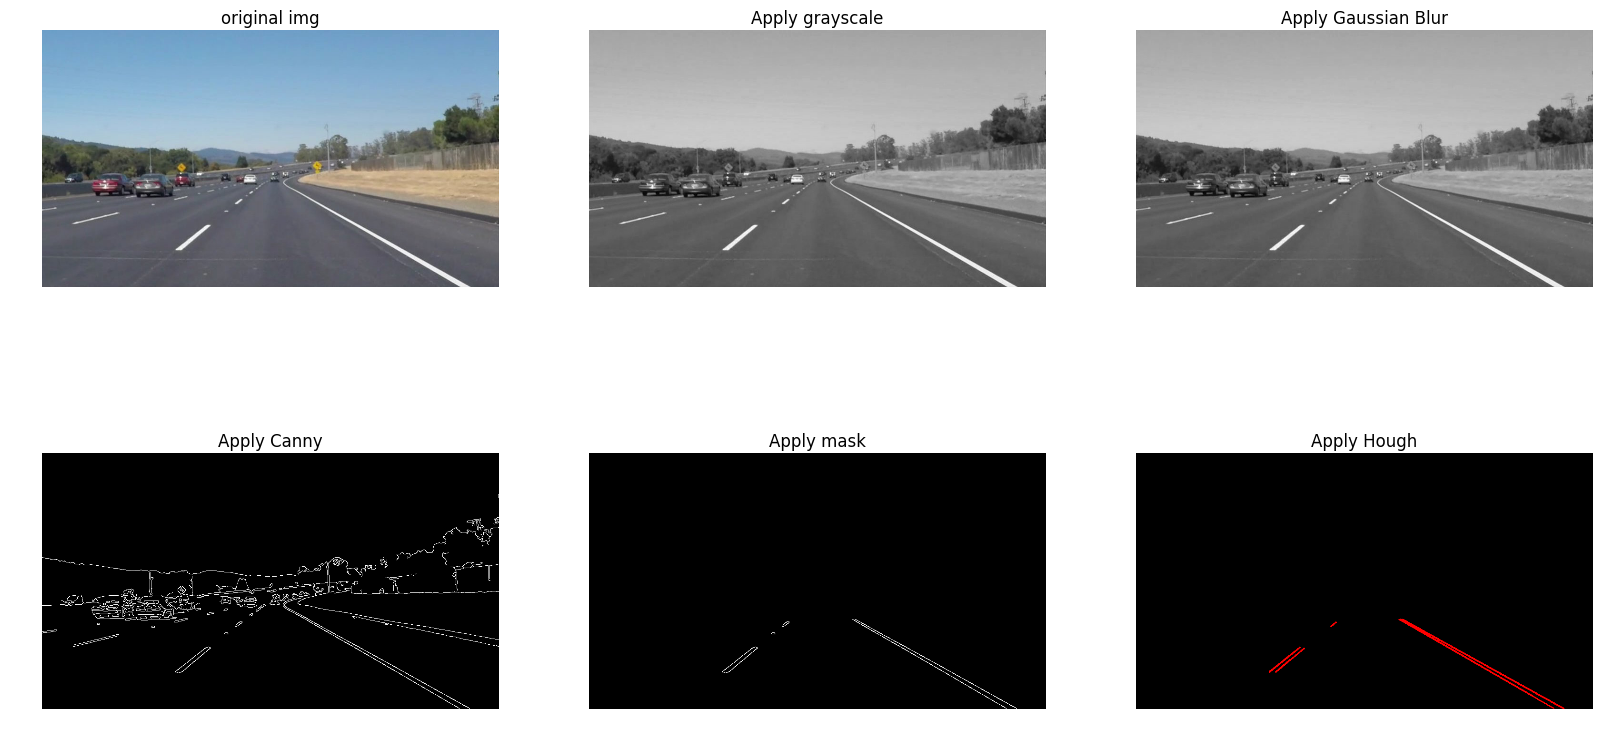

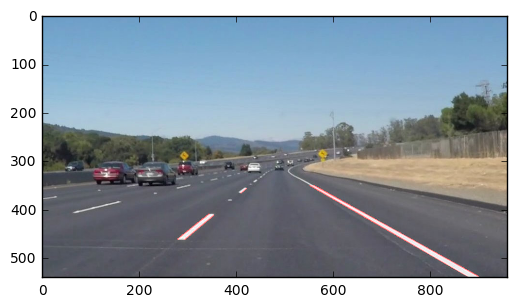

Image: solidWhiteRight.jpg


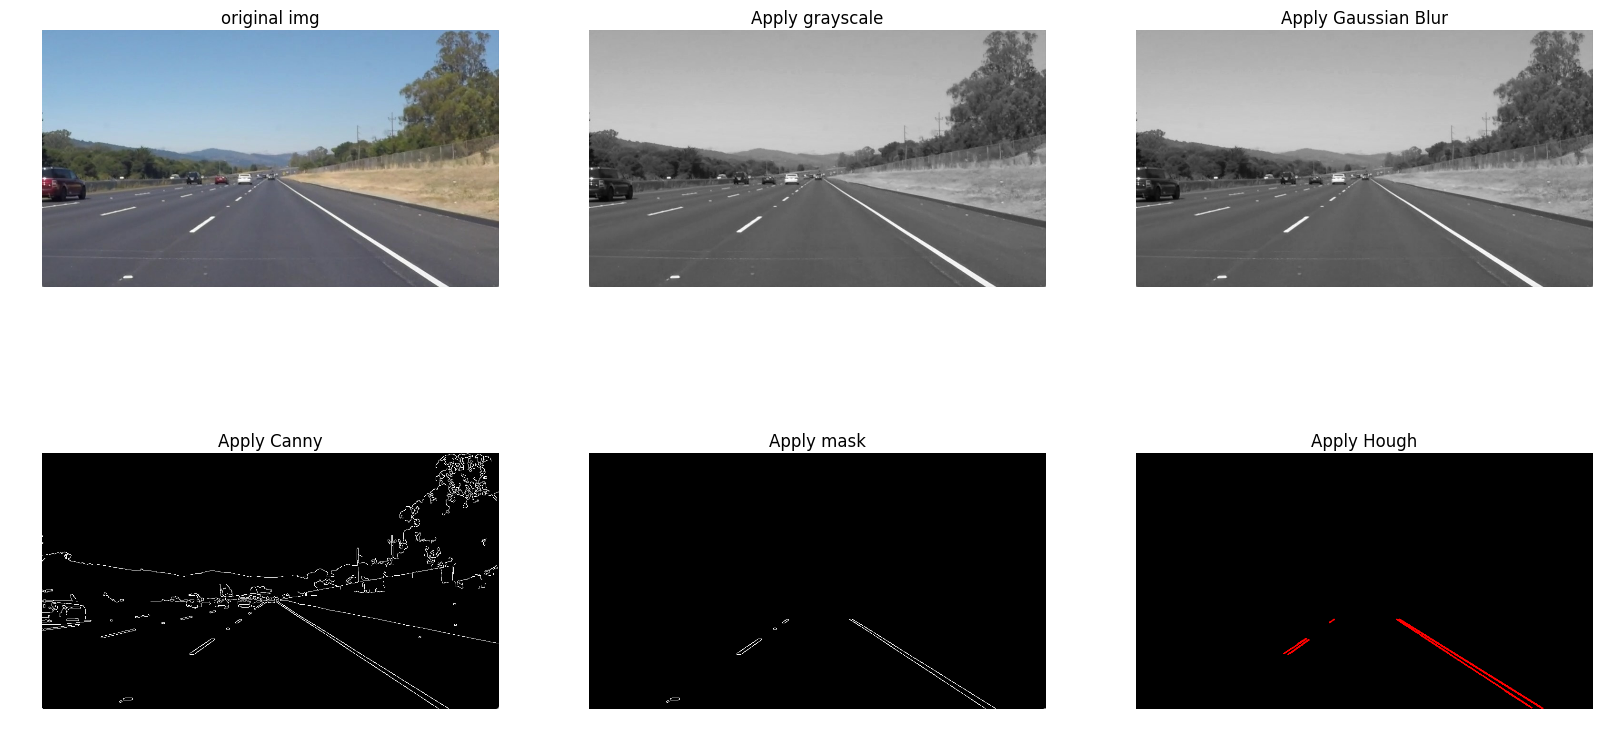

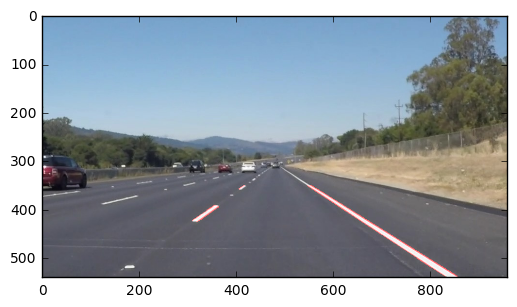

Image: solidYellowCurve.jpg


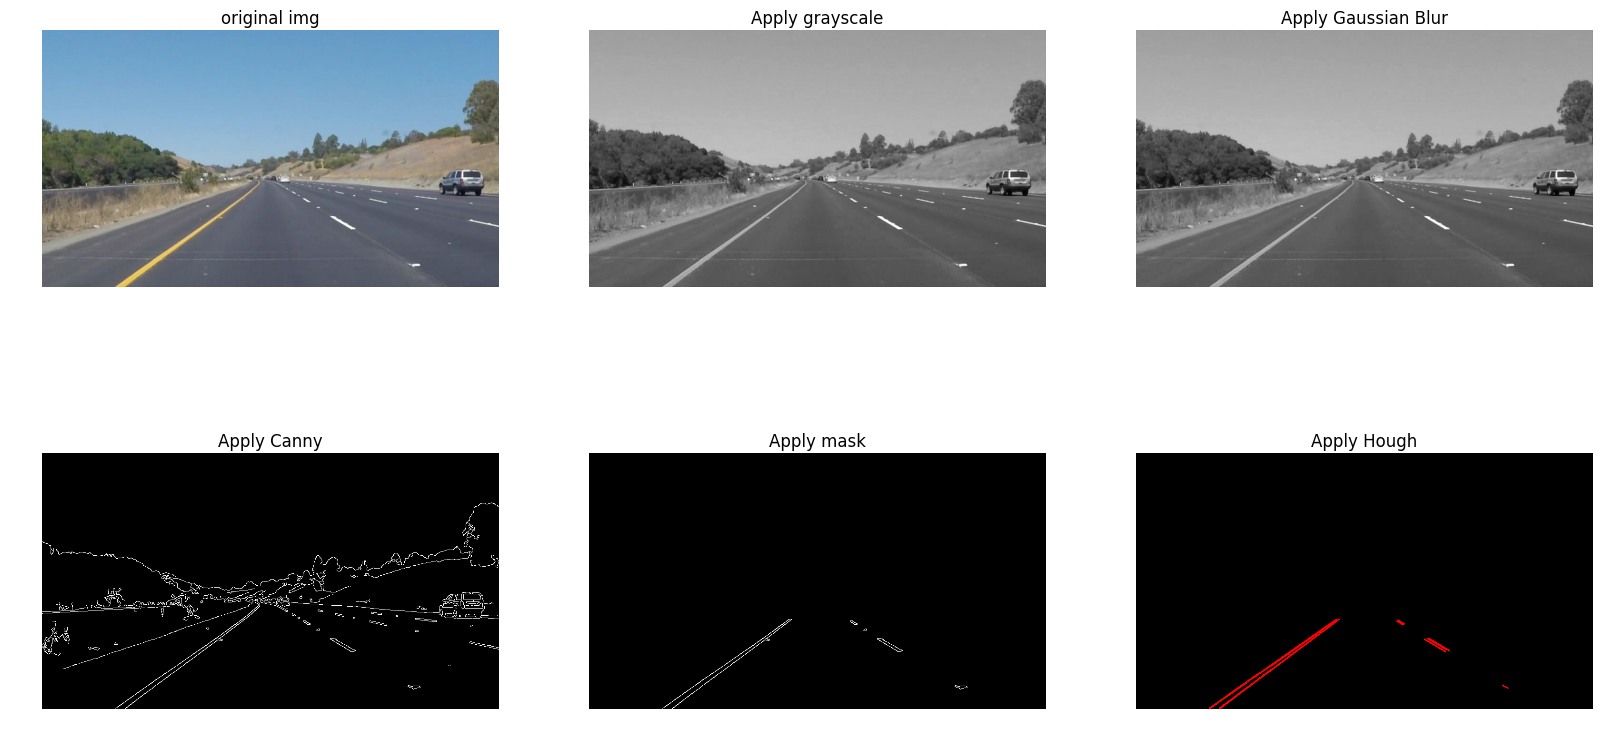

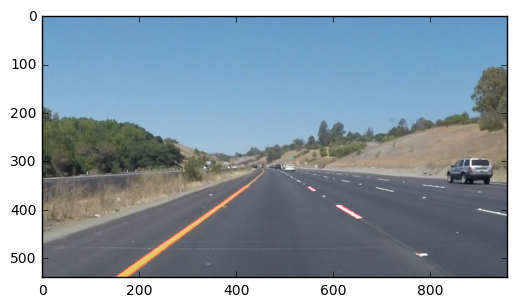

Image: solidYellowCurve2.jpg


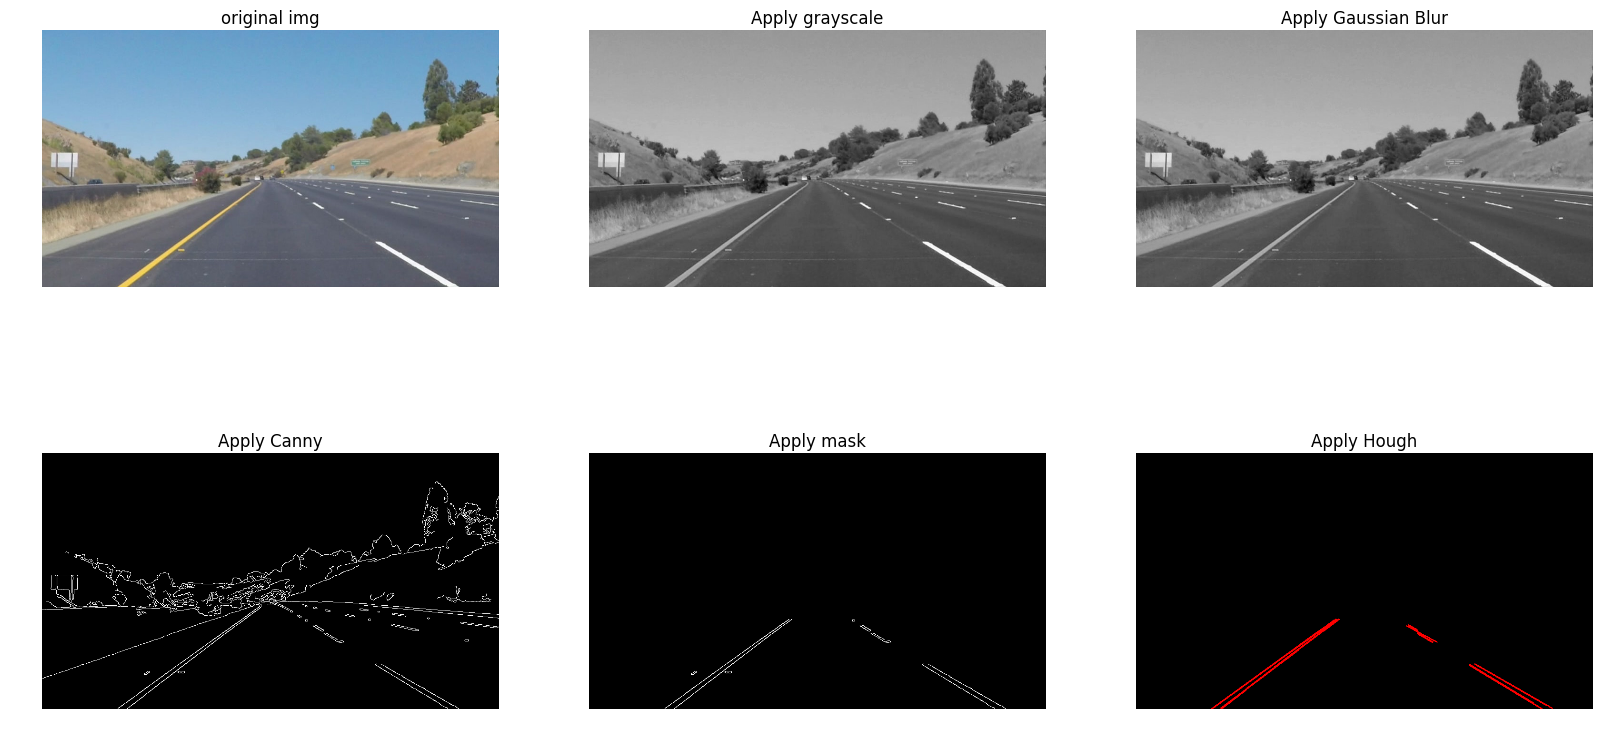

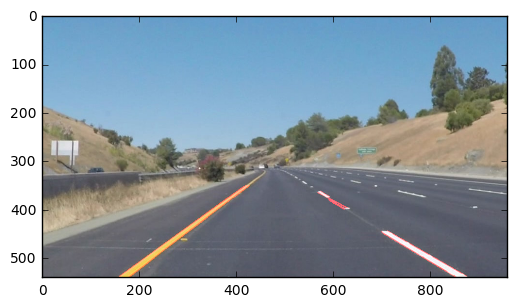

Image: solidYellowLeft.jpg


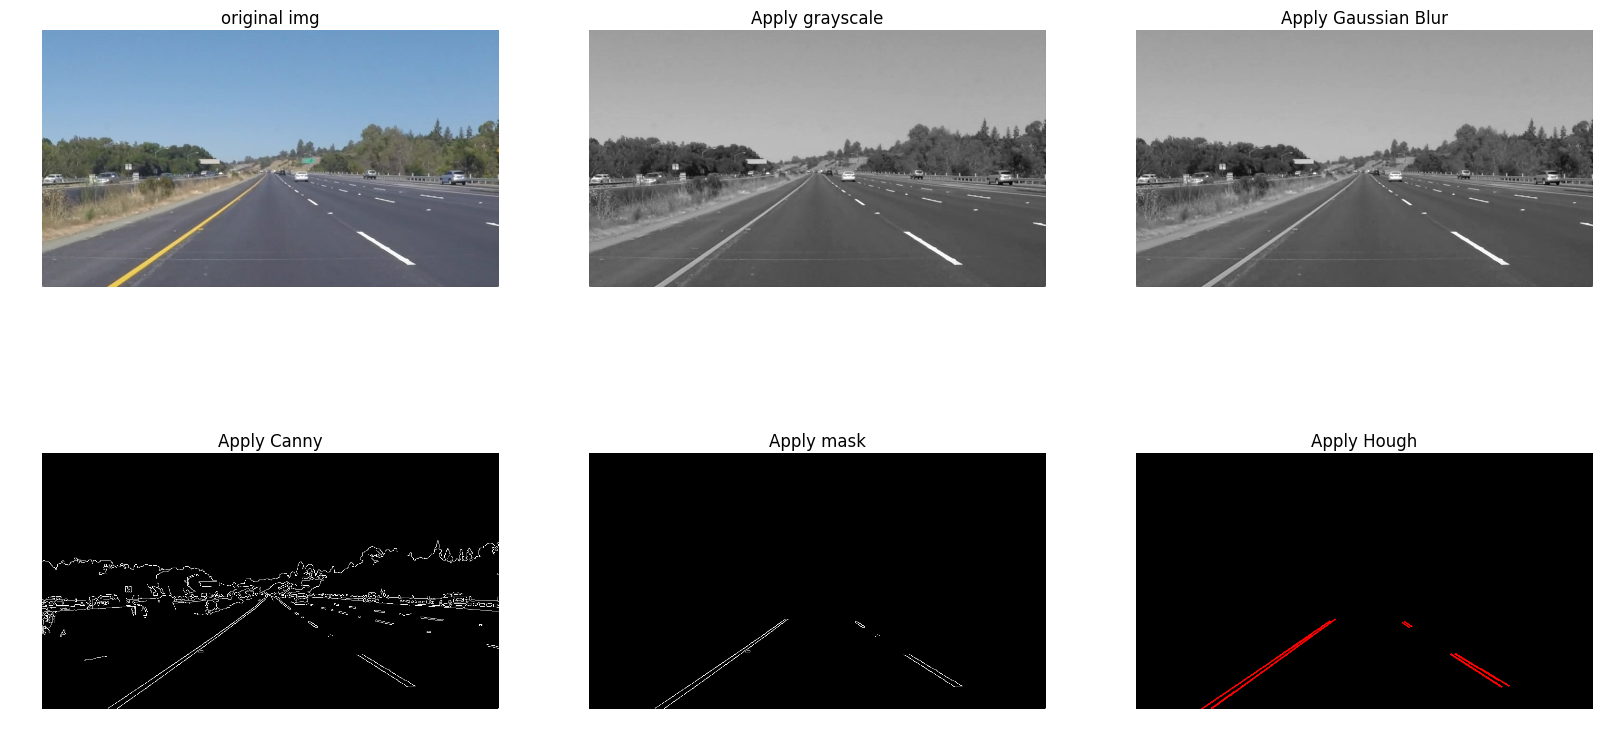

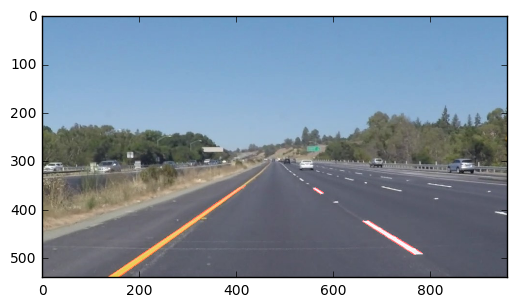

Image: whiteCarLaneSwitch.jpg


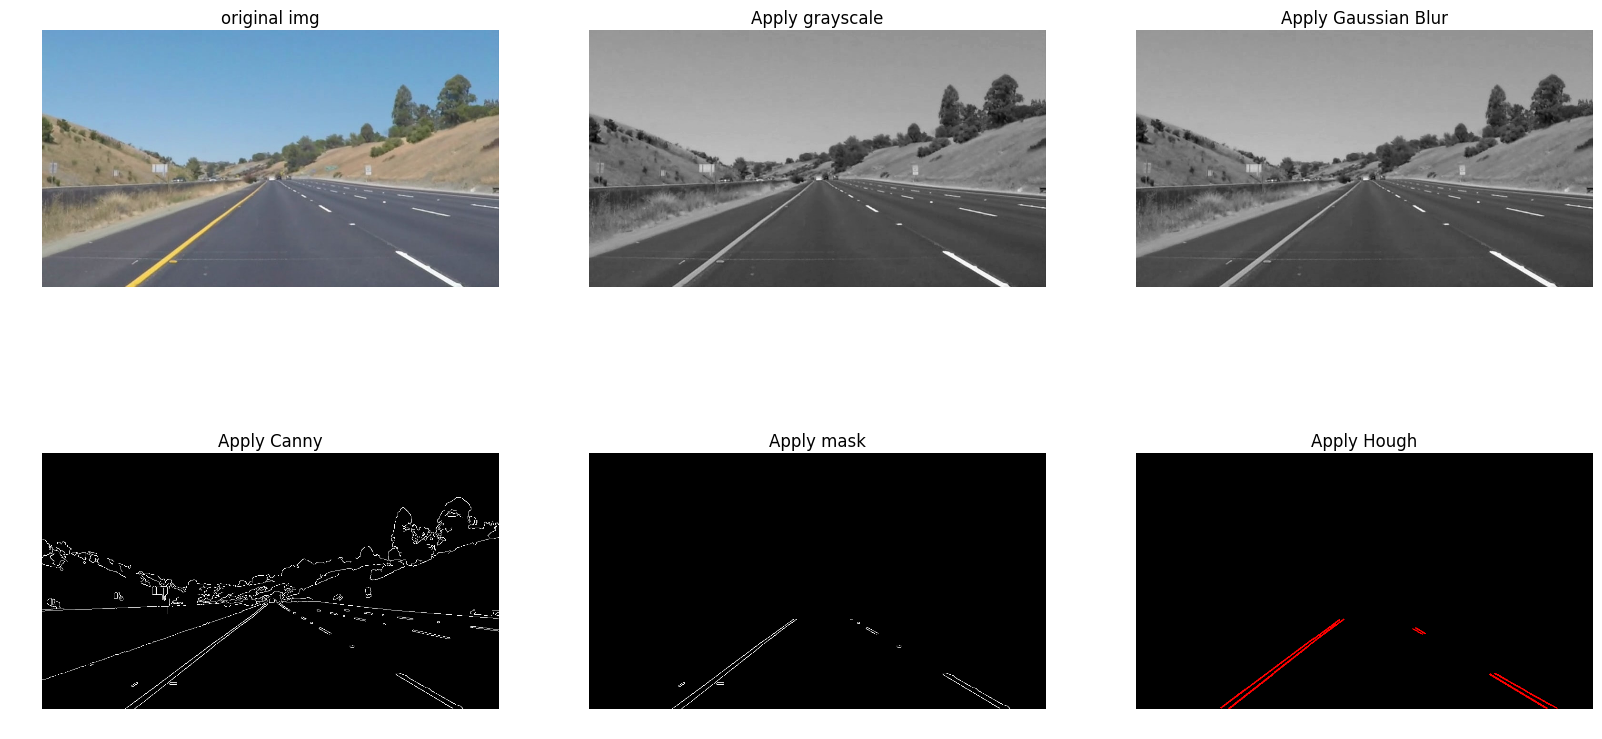

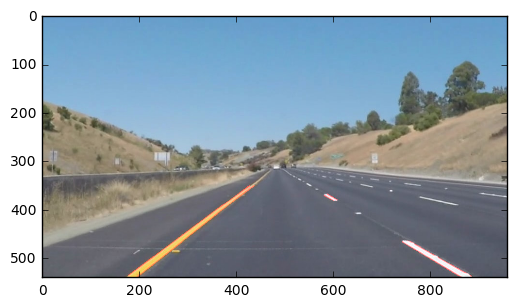

In [4]:
import os
dir_img = "test_images/"
f = os.listdir(dir_img)
f = [fname for fname in f if 'jpeg' in fname or 'jpg' in fname]

def show_img(ax, img, cmap, title):
    if cmap=='gray': 
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(title)

Your parameters here seem reasonable. If you want to play around with some more parameters here, 
check out this link. The tutorial in the link will describe a common method for choosing threshold in Canny Edge Detection.
increase threshold for Hough Transform - it will increase number of intersections needed to detect a line and as a result reduce number of noise and incorrectly defined lines.
increase min_line_len and max_line_gap for Hough Transform to make your lines longer with less number of breaks.
def pipeline(img, vertices, threshold_angle, hline_show ):
    """
    pipeline:
    * vertices
    * threshold_angle
    * display_steps - all (show images at all steps of pipeline) / ='final' (show final image )
    hline_show = {'hough_lines: on/off, 'avg': on/off, 'steps':'on/off'}
    """
    
    #convert to grayscale
    gray = grayscale(img)
    
    #Apply Gaussian Blur: noise smooth noise
    gray_blur = gaussian_blur(gray, 3)
    
    #apply Canny Edge Detector
    '''
    vid5: canny(gray_blur, 80, 120)
    '''
    edges = canny(gray_blur, 10, 180)

    #apply mask
    imshape = img.shape
    masked = region_of_interest(edges, vertices)
    h_lines = hough_lines(masked, rho=1, theta=np.pi/180, threshold=25, min_line_len=10, max_line_gap=10)
    
    #Hough Transform lines
    if hline_show['hlines'] == 'on':                               
        hlines_img = np.zeros(imshape, dtype=np.uint8)
        draw_lines(hlines_img, h_lines, color=[255, 0, 0], thickness=2)
    else:
        hlines_img = np.zeros(imshape, dtype=np.uint8)    
    
    # Angle High Pass filter
    h_lines = hpass_angle_filter(h_lines, threshold_angle)

    # averaging lines
    if hline_show['avg'] == 'on':                           
        avg_hlines = average_lines(img, h_lines, int(img.shape[0]*0.65), img.shape[0])
        avg_img = np.zeros(imshape, dtype=np.uint8)
        draw_lines(avg_img, avg_hlines, color=[255, 0, 0], thickness=10)

    else:
        avg_img = np.zeros(imshape, dtype=np.uint8)
    
    #Display result of each step of the pipeline
    if hline_show['steps'] == 'on':
        _, ax = plt.subplots(2,3, figsize=(20,10))
        show_img(ax[0,0], img, None, 'original img')
        show_img(ax[0,1], gray, 'gray', 'Apply grayscale')
        show_img(ax[0,2], gray, 'gray', 'Apply Gaussian Blur')
        show_img(ax[1,0], edges, 'gray', 'Apply Canny')
        show_img(ax[1,1],masked, 'gray', 'Apply mask')
        show_img(ax[1,2], hlines_img, None, 'Apply Hough')
        plt.show()
    
    img_all_lines = weighted_img(hlines_img, img, α=1, β=0.8, λ=0.)
    img_all_lines = weighted_img(avg_img, img_all_lines, α=1, β=0.8, λ=0.)
    return img_all_lines


for img_name in f:
    #reading in an imag
    print('Image:', img_name)
    img = mpimg.imread(dir_img+img_name)
    hline_show = {'hlines': 'on', 'avg': 'off', 'steps':'on'}
    imshape = img.shape
    vertices = np.array([[(100, imshape[0]), (390, imshape[0]*0.65), \
                          (620, imshape[0]*0.65), (imshape[1], imshape[0]), \
                          (100, imshape[0])]], dtype=np.int32)
    threshold_angle = 25
    lines_img = pipeline(img, vertices, threshold_angle, hline_show)
    plt.imshow(lines_img)
    plt.show()

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # Turn off 'steps' to avoid high memory usage
    hline_show = {'hlines': 'on', 'avg': 'on', 'steps':'off'}
    imshape = img.shape
    vertices = np.array([[(100, imshape[0]), (390, imshape[0]*0.65), \
                          (620, imshape[0]*0.65), (imshape[1], imshape[0]), \
                          (100, imshape[0])]], dtype=np.int32)
    threshold_angle = 25
    return pipeline(image, vertices, threshold_angle, hline_show)

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 33.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.35 s, sys: 1.24 s, total: 4.59 s
Wall time: 7.37 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 35.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 10.8 s, sys: 3.5 s, total: 14.3 s
Wall time: 20.2 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Answers

### Comments

The function **draw_lines_concat()** draws the full extent of the lane.

1. compute the best linear fit for each line and extract the slope (*m*) and the intercept (*b*)
    
    1.1. for each line, separate the data points according to the sign of the slope (*m*<0 and *m*>0)
    
    1.2. if the slope is used as the only 'classification' parameter, there are instances when the lane detection fails. I added one additional condition:
    
<img src="report/img_01.png">

Below is a plot of the datapoints (x1, y1, x2, y2) that makes the Hough line segments. The red (blue) dots are from the segments with a negative (positive) slope: *m* <0 (*m* > 0). The red line is a best linear fit of the red scatters. Because of the 2 outliers, (around (x=750,y=500), the best fit does not follow the expected trend.
Hence, I use an additional classification scheme for left and right lane: 

    1.3 the absolute value of the angle of the segment must be larger than some threshold value ($\phi=$20deg, for example): 
    
$ \phi = \left|\  arctan \left[ \frac{y2 - y1}{x2 - x1} ) \right] \ \right| \times \frac{180}{\pi} $



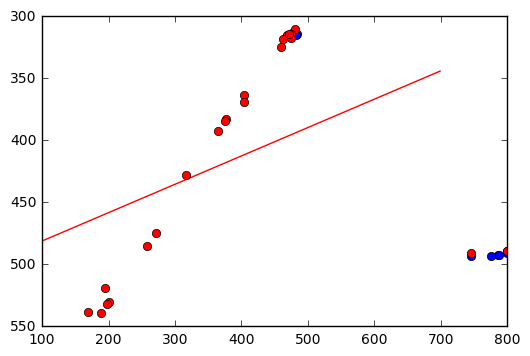

In [11]:
left = np.array([[194, 519], [481, 310], [271, 475], [469, 315], [317, 428], [474, 314], [201, 530], [463, 318], [169, 538], [474, 317], [376, 383], [471, 314], [198, 532], [375, 384], [745, 491], [800, 489], [258, 485], [404, 363], [189, 539], [364, 392], [404, 369], [459, 325]])

right = np.array([[476, 313], [786, 492], [483, 314], [799, 489], [478, 313], [788, 492], \
            [482, 315], [799, 491], [746, 493], [775, 493]])

m, b = np.polyfit(left[:,0],left[:,1], 1)
plt.gca().invert_yaxis()
plt.plot(np.arange(100,700), m*np.arange(100,700)+b, color='red' )
plt.plot(right[:,0], right[:,1], 'bo')
plt.plot(left[:,0], left[:,1], 'ro')

plt.show()


Below is the extent of the lane for the same frame, when using both the sign of the slope ($m$) and the angle of the segments with the $x$ axis: ($\phi > 20deg$):

<img src="report/img_02.png">



### Reflections

The performance of the lane detector algorithm, developed here, is greatly affected by spurious 'signals' such as shadows, defects on the road, in fact any defects in the region of interest.
Some of the "bad" segments (i.e the segments that do not follow the lane) can be filtered using a high band pass filter. However, this is not sufficient in some cases (see option challenge).
In addition, the algorithm as it is is not suitable to track curved line.

The following filtering scheme were used to improve the performance of the algorithm in the Optional Challenge:

1. By pass angle filter: remove segments with too acute or too obtuse angles.
2. Fetch yellow-ish tone and replace by white.
3. dilate features before edge detection

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [27]:
def bypass_angle_filter(lines, low_thres, hi_thres):  
    """ 
    By Pass angle filter: unlike the earlier filter, this filter removes any lines with angle outside the range
    [low_threshold, high_threshold[
    
    """
    if lines != None : #if no lines left or right are detected
        filtered_lines = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                angle = abs(np.arctan( (y2-y1)/(x2-x1) ) * 180/np.pi )
                if angle > low_thres and angle < hi_thres:
                    filtered_lines.append([[x1,y1,x2,y2]])
    
        return filtered_lines  

def yellow_enhance(img_rgb):
    '''
    the function takes a RGB image replace yellow-ish color by white:
    * convert image to HSV (make it easier to work out the range of yellow color to track)
    * create a lower/upper range of HSV
    * create a mask
    '''
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    lower_yellow = np.array([40, 100, 20])
    upper_yellow = np.array([100,255,255])
    mask = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    gray = grayscale(img_rgb)
    return weighted_img(mask, gray, α=1., β=1., λ=0.)
    
    
def pipeline(img, vertices, low_thres, hi_thres, hline_show ):
    """
    pipeline:
    * vertices
    * threshold_angle
    * display_steps - all (show images at all steps of pipeline) / ='final' (show final image )
    hline_show = {'hough_lines: on/off, 'avg': on/off, 'steps':'on/off'}
    """
    #convert to grayscale + enhance yellow-ish tone
    gray = yellow_enhance(img) 
    #remove/cleanup noise
    gray_blur = gaussian_blur(gray, 3)
    #Dilate features for large gap between edges line
    gray = cv2.dilate(gray, (3, 3), iterations = 10)
    #Equalized histogram, thresholded, and skeletonized image of the ROI: 
    #Apply Gaussian Blur: noise smooth noise
    

    #apply Canny Edge Detector
    edges = canny(gray, 50, 180)
    
    #apply mask
    imshape = img.shape
    masked = region_of_interest(edges, vertices)
      
    h_lines = hough_lines(masked, rho=1, theta=np.pi/180, threshold=26, min_line_len=5, max_line_gap=50)
    
    #Hough Transform lines
    if hline_show['hlines'] == 'on':                               
        hlines_img = np.zeros(imshape, dtype=np.uint8)
        draw_lines(hlines_img, h_lines, color=[255, 0, 0], thickness=4)
    else:
        hlines_img = np.zeros(imshape, dtype=np.uint8)    
    
    # Angle High Pass filter
    h_lines = bypass_angle_filter(h_lines, low_thres, hi_thres)

    # averaging lines
    if hline_show['avg'] == 'on':                           
        avg_hlines = average_lines(img, h_lines, int(img.shape[0]*0.65), img.shape[0])
        avg_img = np.zeros(imshape, dtype=np.uint8)
        draw_lines(avg_img, avg_hlines, color=[255, 0, 0], thickness=10)

    else:
        avg_img = np.zeros(imshape, dtype=np.uint8)
    
    #Display result of each step of the pipeline
    if hline_show['steps'] == 'on':
        _, ax = plt.subplots(2,3, figsize=(10,4))
        show_img(ax[0,0], img, None, 'original img')
        show_img(ax[0,1], gray, 'gray', 'Apply grayscale')
        show_img(ax[0,2], gray, 'gray', 'Apply Gaussian Blur')
        show_img(ax[1,0], edges, 'gray', 'Apply Canny')
        show_img(ax[1,1],masked, 'gray', 'Apply mask')
        show_img(ax[1,2], hlines_img, None, 'Apply Hough')
        plt.show()
    
    img_all_lines = weighted_img(hlines_img, img, α=1., β=0.8, λ=0.)
    img_all_lines = weighted_img(avg_img, img_all_lines, α=1., β=0.8, λ=0.)
    return img_all_lines

In [28]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    # Turn off 'steps' to avoid high memory usage
    hline_show = {'hlines': 'off', 'avg': 'on', 'steps':'off'}
    imshape = [720, 1280]
    vertices = np.array([[(200, imshape[0]-80), (490, imshape[0]*0.65), \
                          (820, imshape[0]*0.65), (imshape[1]-150, imshape[0]-80), \
                          (100, imshape[0]-80)]], dtype=np.int32)
    
    low_thres, hi_thres = [30, 80]
    return pipeline(image, vertices, low_thres, hi_thres, hline_show)

In [29]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:17<00:00, 14.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 10.4 s, sys: 2.95 s, total: 13.3 s
Wall time: 19.2 s


In [31]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Lane Lines Detection during night 

The algorithm is tested in a different environment/condition: during night drive.
The video is recorded using a cellphone placed on the dashboard (it is not strongly held in place, hence the vibration)
There are a few sources of "spurrious signals": 
    
    * reversed traffic: cars have the head lights on
    * same way traffic with back light on
    * non uniform luminosity for the entire clip
    * lines are harder to see
    * poor video resolution (ok, that one is on me :-) ) 
    * "bad" orientation of the cellphone: tilted up.
    
Towards the end of the clip, there is "a change of lane" and "a turn to the right".

The red lines are the Hough lines and the two green Lines are the extended lines.

Despite traffic and other sources of noise, the tracking of the lanes is fairly accurate for the first portion of the movie. The algorithm seems to be robust enough to handle lane changes: it is still able to track the lane. When the lane is outside the ROI, there is no tracking although the lane seems to be in a close vicinity to the car. The main problem of the algorithm is that it is lost when the car makes a turn: the extended lines jump all over the place.

Below is a demonstration.

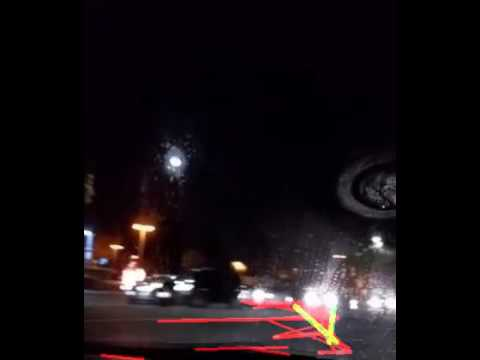

In [30]:
from IPython.display import YouTubeVideo
YouTubeVideo("rTI2WcV2ZyE")